# Analysing density of cuts as an excitement modelling parameter

This part of code mimicks the fact that whenever there is an important event, the director immediately increases the density of cuts trying to show everything that is appening on the field and among the spectators at that moment. This increase in cut density also appears whenever there is an important break (e.g. due to foul play, free kick, etc.). Generally in sports only fast cuts are used, not fade ins or fade outs or others.

In [ ]:
%matplotlib inline

import cv2 
import moviepy.editor 
import numpy as np
import matplotlib.pyplot as plt
import math

The detect_cuts Algorithm based on luminosity changes was taken from the moviepy library. Here the luminosity is calculated for each frame by summing the puxel values. Then the difference in values is calculated for consecutive frames. The difference greater than a threshhold are dected as cuts.
The fps was set to 10, for faster processing

In [2]:
def detect_cuts(clip, luminosities=None, thr=10.0, progress_bar=False, fps=10):
    """
    This algorithm was taken from the
    tools for automating video editing
    in the moviepy library """ 
    
    if luminosities is None:
        luminosities = [f.sum() for f in clip.iter_frames(fps=fps, dtype='uint32', progress_bar=1)]
        luminosities = np.array(luminosities, dtype=float)
        if clip is not None:
            end = clip.duration
        else:
            end = len(luminosities)*(1.0/fps) 
        lum_diffs = abs(np.diff(luminosities))
        avg = lum_diffs.mean()
        luminosity_jumps = 1+np.array(np.nonzero(lum_diffs > thr*avg))[0]
        tt = [0]+list((1.0/fps) *luminosity_jumps) + [end]
        return tt
        
        

#reading an hour long soccer video at a low resolution
clip=moviepy.editor.VideoFileClip("sample.mp4",target_resolution=(240,None))

#get time (in secs) for frames where cuts are detected
cuts_frame_time = detect_cuts(clip)
    

100%|██████████| 33721/33721 [15:11<00:00, 36.99it/s]


To calculate the density of cuts,we calculate prev_cut(k) and next_cut(k), the frame indexes of the two closest cuts respectively left (previous) and right (next) to frame number k. Here delta=100 is the scaling constant.

[![image.png](https://s5.postimg.org/ce17qbb53/image.png)](https://postimg.org/image/8hnvubq5f/)

In [4]:
def next_cut(f_time):
    for j in cuts_frame_time:
        if(j-f_time >0 ):
            break
    return j

def prev_cut(f_time):
    for k in reversed(cuts_frame_time):
        if(k-f_time <0):
            break 
    return k
    
fr_num= np.arange(.1, clip.duration , .1 ) #x-axis

density_cuts=list()
for i in range(1, int(math.ceil(clip.duration*10))):
    #print i
    density_cuts.append(100*(math.exp((1-(next_cut(i/10.0)- prev_cut(i/10.0)))/100)))

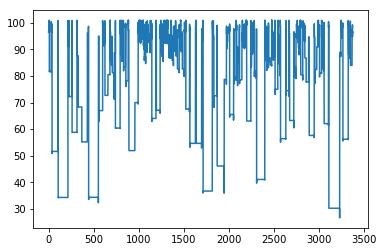

In [5]:
plt.plot(fr_num, density_cuts)

### smoothing out the curve
Kaiser funtion of length = clip.duration and shape parameter=5 is convoluted with the density_cuts step curve to get a smooth_cut_density curve.

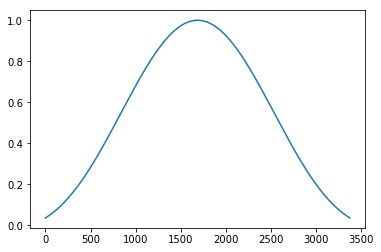

In [6]:
kaiser_func=np.kaiser(int(clip.duration),5)
plt.plot(kaiser_func)

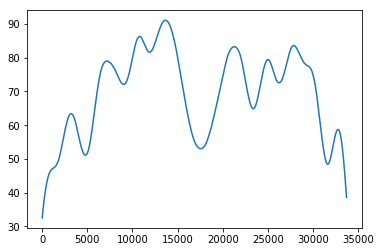

In [7]:
smooth_cut_density = np.convolve(kaiser_func/kaiser_func.sum(),density_cuts,mode='same')
plt.plot(smooth_cut_density)

In [8]:
len(smooth_cut_density)

33720

### Peak events
The peaks of smooth_cut_density curve were detected by finding points having both increase AND decrease. The nearby peaks were filtered out and the higher peaks were selected.

### Actual vs decected peaks
[![edit_cuts_density.jpg](https://s5.postimg.org/bfy4sakkn/edit_cuts_density.jpg)](https://postimg.org/image/o7caysucj/)



In [13]:
def get_filtered_peaks(smooth_cut_density):
    #find peaks from the curve
    increases = np.diff(smooth_cut_density)[:-1]>=0
    decreases = np.diff(smooth_cut_density)[1:]<=0
    peaks_position = (increases * decreases).nonzero()[0]
    peaks_value = smooth_cut_density[peaks_position]
    peaks_position = peaks_position[peaks_value>np.percentile(peaks_value,10)]
    
    #filter two close (100 frames apart) peaks
    final_peaks_position=[peaks_position[0]]
    for fr_num in peaks_position:
        if (fr_num - final_peaks_position[-1]) < 100:
            if smooth_cut_density[fr_num] > smooth_cut_density[final_peaks_position[-1]]:
                final_peaks_position[-1] = fr_num
        else:
            final_peaks_position.append(fr_num)
        
    final_times = [i/10 for i in final_peaks_position]
    return final_times
    

final_cuts_times = get_filtered_peaks(smooth_cut_density)
print 'time of peaks (in secs) =', final_cuts_times

final = moviepy.editor.concatenate([clip.subclip(max(t-4,0),min(t+4, clip.duration))
                     for t in final_cuts_times])
#final.ipython_display()
final.to_videofile('summary_by_cuts_density.mp4')

time of peaks (in secs) = [720, 1078, 1358, 2136, 2501, 2624, 2787]
[MoviePy] >>>> Building video summary_by_cuts_density.mp4
[MoviePy] Writing audio in summary_by_cuts_densityTEMP_MPY_wvf_snd.mp3


100%|██████████| 1235/1235 [00:02<00:00, 602.18it/s]

[MoviePy] Done.
[MoviePy] Writing video summary_by_cuts_density.mp4



100%|██████████| 3357/3357 [00:29<00:00, 115.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: summary_by_cuts_density.mp4 

